/Users/pavelmanyakin/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[*********************100%%**********************]  1 of 1 completed


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02  326.100006  329.980011  324.779999  329.809998  329.809998   
2020-01-03  326.779999  329.859985  325.529999  325.899994  325.899994   
2020-01-06  323.119995  336.359985  321.200012  335.829987  335.829987   
2020-01-07  336.470001  336.700012  330.299988  330.750000  330.750000   
2020-01-08  331.489990  342.700012  331.049988  339.260010  339.260010   
...                ...         ...         ...         ...         ...   
2024-05-08  601.630005  618.219971  601.630005  609.469971  609.469971   
2024-05-09  614.400024  615.719971  605.750000  612.090027  612.090027   
2024-05-10  619.000000  623.979980  605.059998  610.869995  610.869995   
2024-05-13  614.299988  618.219971  606.830017  616.590027  616.590027   
2024-05-14  615.169983  621.479980  608.400024  613.659973  613.659973   

             Volume  
Date           

[219/300] Loss: 37.671926975250244
[220/300] Loss: 37.260305881500244
[221/300] Loss: 36.867764949798584
[222/300] Loss: 36.49836254119873
[223/300] Loss: 36.15842962265015
[224/300] Loss: 35.84084987640381
[225/300] Loss: 35.55223608016968
[226/300] Loss: 35.29207420349121
[227/300] Loss: 35.05176877975464
[228/300] Loss: 34.833797454833984
[229/300] Loss: 34.628026485443115
[230/300] Loss: 34.43341827392578
[231/300] Loss: 34.24106693267822
[232/300] Loss: 34.04652214050293
[233/300] Loss: 33.84843683242798
[234/300] Loss: 33.639315605163574
[235/300] Loss: 33.416229248046875
[236/300] Loss: 33.177199840545654
[237/300] Loss: 32.92678880691528
[238/300] Loss: 32.6630802154541
[239/300] Loss: 32.39339542388916
[240/300] Loss: 32.114805698394775
[241/300] Loss: 31.826645851135254
[242/300] Loss: 31.549243450164795
[243/300] Loss: 31.273932456970215
[244/300] Loss: 30.997090816497803
[245/300] Loss: 30.73027491569519
[246/300] Loss: 30.470237016677856
[247/300] Loss: 30.216579914093018


[91/165] LossD: 9.68833601474762 LossG:4.911529242992401
[92/165] LossD: 9.637316346168518 LossG:4.8892048597335815
[93/165] LossD: 9.678356528282166 LossG:4.890120089054108
[94/165] LossD: 9.688873171806335 LossG:4.880015134811401
[95/165] LossD: 9.656496167182922 LossG:4.9126046895980835
[96/165] LossD: 9.598710417747498 LossG:4.910743236541748
[97/165] LossD: 9.672346115112305 LossG:4.875233173370361
[98/165] LossD: 9.610934615135193 LossG:4.898778438568115
[99/165] LossD: 9.625041484832764 LossG:4.908076763153076
[100/165] LossD: 9.634074568748474 LossG:4.901888310909271
[101/165] LossD: 9.66490888595581 LossG:4.901894211769104
[102/165] LossD: 9.644518375396729 LossG:4.943487644195557
[103/165] LossD: 9.585260391235352 LossG:4.906735718250275
[104/165] LossD: 9.680495262145996 LossG:4.892888844013214
[105/165] LossD: 9.632867217063904 LossG:4.913631558418274
[106/165] LossD: 9.582333207130432 LossG:4.918340563774109
[107/165] LossD: 9.672303438186646 LossG:4.95168274641037
[108/16

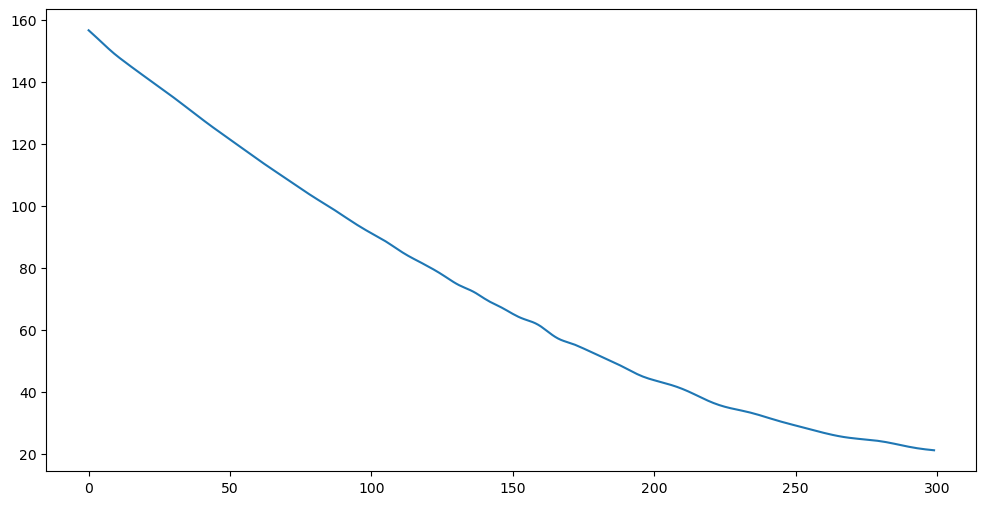

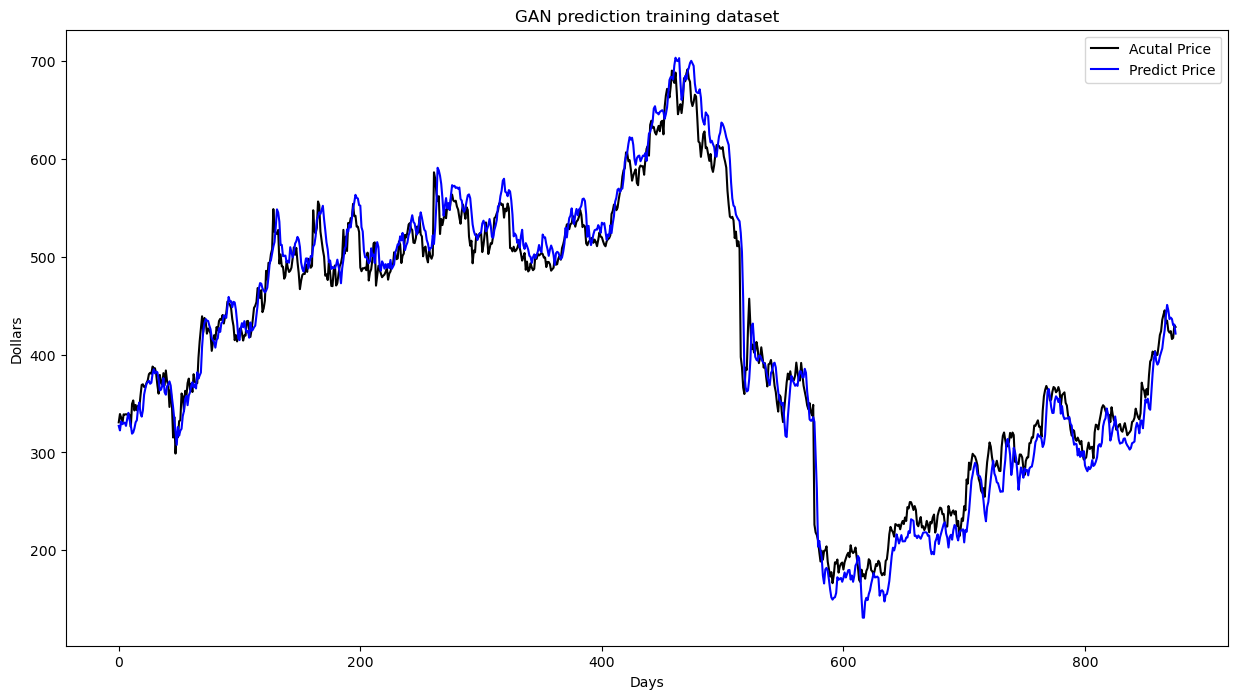

In [1]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
ticker_symbol = 'NFLX'

data = yf.download(ticker_symbol, start="2020-01-01", end=dt.date.today())

print(data)
data['y'] = data['Close'].copy()

x = data.iloc[:, :6].values
y = data.iloc[:, 6].values


split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([6, 100, 100, 100, 10], 10)
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.00016
num_epochs = 165

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(16).to(device)
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())
plt.figure(figsize=(15, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('Dollars')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [95]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
import matplotlib.pyplot as plt

end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=7)
data = yf.download('NFLX', start=start_date, end=end_date, interval='1h')
data['Close'] = data['Close'].fillna(method='ffill')

x = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values
y = data['Close'].values
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(x)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

def create_dataset(x, time_steps=24):
    x_new = []
    for i in range(time_steps, len(x)):
        x_new.append(x[i-time_steps:i])
    return np.array(x_new)

time_steps = 24
x_new = create_dataset(x_scaled, time_steps)


[*********************100%%**********************]  1 of 1 completed
/var/folders/ml/w52lgnpd681dr_dyz7dhqz9r0000gn/T/ipykernel_76788/2748128592.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Close'] = data['Close'].fillna(method='ffill')


In [96]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(torch.tensor(x_new, dtype=torch.float32))
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        return self.sigmoid(self.fc3(x))

time_steps = x_new.shape[1]
num_features = x_new.shape[2]
flattened_input_dim = time_steps * num_features

generator = Generator(input_dim=flattened_input_dim, hidden_dim=128, output_dim=flattened_input_dim)
discriminator = Discriminator(input_dim=flattened_input_dim)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
criterion = nn.BCELoss()

epochs = 100
for epoch in range(epochs):
    for x_batch in train_loader:
        real_data = x_batch[0].view(-1, flattened_input_dim)  # Flatten the data correctly

        real_labels = torch.ones(real_data.size(0), 1)
        fake_labels = torch.zeros(real_data.size(0), 1)

        # Train discriminator
        discriminator.zero_grad()
        real_loss = criterion(discriminator(real_data), real_labels)

        # Generate fake data
        noise = torch.randn(real_data.size(0), flattened_input_dim)  # Ensure noise dimension matches generator input
        fake_data = generator(noise)
        fake_loss = criterion(discriminator(fake_data.detach()), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Train generator
        generator.zero_grad()
        g_loss = criterion(discriminator(fake_data), real_labels)
        g_loss.backward()
        g_optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')


Epoch [1/100], d_loss: 1.3597780466079712, g_loss: 0.6417065262794495
Epoch [2/100], d_loss: 1.3510593175888062, g_loss: 0.6398467421531677
Epoch [3/100], d_loss: 1.341005563735962, g_loss: 0.6392526030540466
Epoch [4/100], d_loss: 1.3300654888153076, g_loss: 0.6391516327857971
Epoch [5/100], d_loss: 1.3209631443023682, g_loss: 0.6375911235809326
Epoch [6/100], d_loss: 1.3084402084350586, g_loss: 0.6392629146575928
Epoch [7/100], d_loss: 1.3007054328918457, g_loss: 0.6363942623138428
Epoch [8/100], d_loss: 1.290910005569458, g_loss: 0.6353016495704651
Epoch [9/100], d_loss: 1.2816505432128906, g_loss: 0.6337512731552124
Epoch [10/100], d_loss: 1.270659327507019, g_loss: 0.6337940692901611
Epoch [11/100], d_loss: 1.2584009170532227, g_loss: 0.6347745656967163
Epoch [12/100], d_loss: 1.2517658472061157, g_loss: 0.6307905316352844
Epoch [13/100], d_loss: 1.2421420812606812, g_loss: 0.629145622253418
Epoch [14/100], d_loss: 1.229192852973938, g_loss: 0.6306979656219482
Epoch [15/100], d_lo

In [97]:
generator.eval()
noise = torch.randn(1, flattened_input_dim)
generated_data = generator(noise)
predicted_prices = y_scaler.inverse_transform(generated_data.detach().numpy().reshape(-1, 1))
time_steps = x_new.shape[1]
num_features = x_new.shape[2]
flattened_input_dim = time_steps * num_features

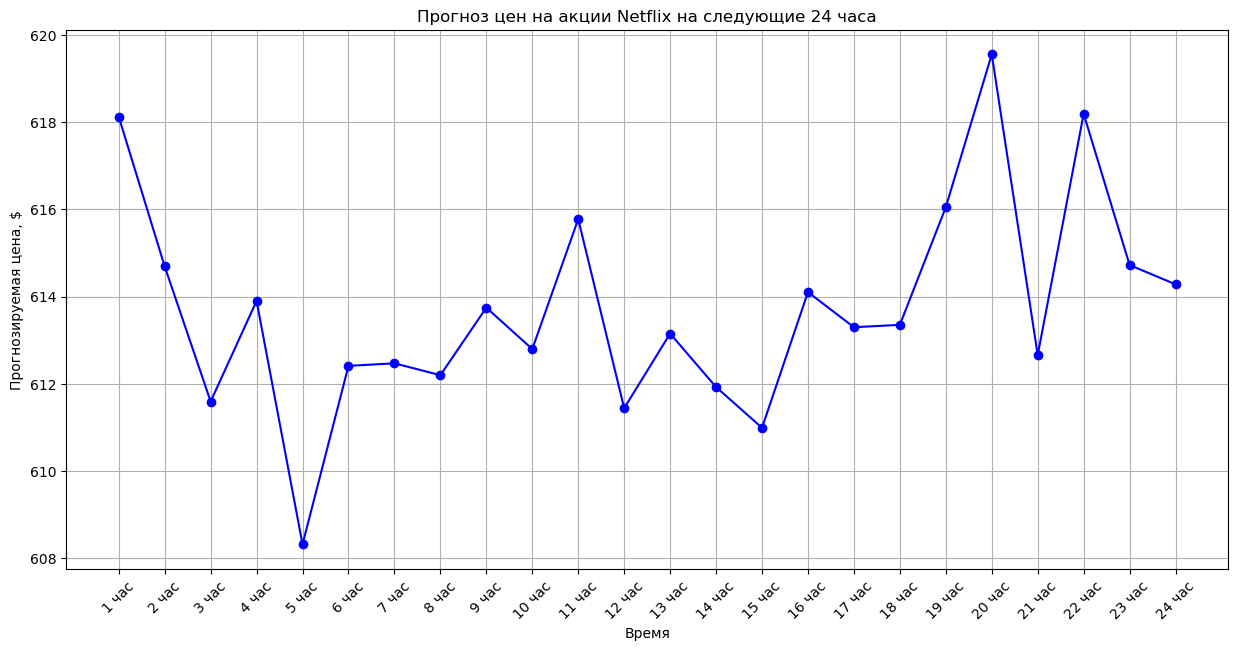

In [98]:
import numpy as np


if predicted_prices.size != 24:
    predicted_prices = predicted_prices.reshape(24, -1).mean(axis=1)

assert predicted_prices.size == 24, "The number of predicted prices must be 24."

hours = [f"{i+1} час" for i in range(24)]

plt.figure(figsize=(15, 7))
plt.plot(hours, predicted_prices, marker='o', linestyle='-', color='blue')
plt.title('Прогноз цен на акции Netflix на следующие 24 часа')
plt.xlabel('Время')
plt.ylabel('Прогнозируемая цена, $')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
